# glasma configuration

In [1]:
N = 256
# N = 512
L = 6.0

# define hbar * c in units of GeV * fm
hbarc = 0.197326 

a = L / N
E0 = 1 / a * hbarc

mu = 0.5
m = 0.2
uv = 20.0
ns = 20

g = 2.0
DTS = 8
dt = 1.0 / DTS

In [2]:
# Set environment variables 
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["GAUGE_GROUP"] = "su2"
os.environ["PRECISION"] = "double"
os.environ["REPRESENTATION"] = "fundamental"

# Import curraun and other packages
import sys
sys.path.append('..')

import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
from curraun import wong
initial.DEBUG = False
wong.DEBUG = True
import curraun.su as su
from curraun.wong import init_charge

from curraun.numba_target import use_cuda, use_numba
if use_cuda:
    from numba import cuda

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex=True)
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams.update({'font.size':18})

Using CUDA
Using SU(2)
Using double precision
Using double precision
Using double precision


# glasma initialization

In [3]:
s = core.Simulation(N, dt, g)
va = mv.wilson(s, mu=mu / E0, m=m / E0, uv=uv / E0, num_sheets=ns)
vb = mv.wilson(s, mu=mu / E0, m=m / E0, uv=uv / E0, num_sheets=ns)
initial.init(s, va, vb)

# wong initialization

In [4]:
n_particles = 10000
wong_solver = wong.WongSolver(s, n_particles)

In [5]:
# add particles at center with random pT
pT = 0.5 / E0

x0s = np.zeros((n_particles, 3))
p0s = np.zeros((n_particles, 4))
q0s = np.zeros((n_particles, su.ALGEBRA_ELEMENTS))
# mass = 1.5/E0 # charm quark mass
mass = 100./E0 # infinite mass limit
masses = mass * np.ones(n_particles)

for i in range(n_particles):
    xT = np.random.rand(2) * s.n
    x0 = [xT[0], xT[1], 0.0]
    
    angle = 2*np.pi*np.random.rand(1)
    p0 = [0.0, pT * np.cos(angle), pT * np.sin(angle), 0.0]
    
    q0 = init_charge()

    # wong_solver.add_particle(x0, p0, q0, mass)

    x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

wong_solver.initialize(x0s, p0s, q0s, masses)

# glasma + wong evolution

In [6]:
tau_max = 2.0
t_max = int(tau_max / a * DTS)

# position, momentum and charge history
xs = np.zeros((t_max, n_particles, 3))
ps = np.zeros((t_max, n_particles, 4))
qs = np.zeros((t_max, n_particles, su.GROUP_ELEMENTS))

corr = np.zeros((t_max, n_particles, 3))

if wong.DEBUG:
    cs = np.zeros((t_max, n_particles, su.CASIMIRS))

for t in range(t_max):
    core.evolve_leapfrog(s)
    wong_solver.evolve()
    if wong.DEBUG:
        wong_solver.compute_casimirs()
        cs[t] = wong_solver.c.copy()
    xs[t] = wong_solver.x0.copy()
    ps[t] = wong_solver.p.copy()
    qs[t] = wong_solver.q.copy()

    wong_solver.compute_lorentz_force()
    if t==0:
        f0 = wong_solver.f.copy()
    f = wong_solver.f.copy()
    wong_solver.compute_lorentz_force_correlator(f0, f)
    corr[t] = wong_solver.corr.copy()

# plotting trajectories

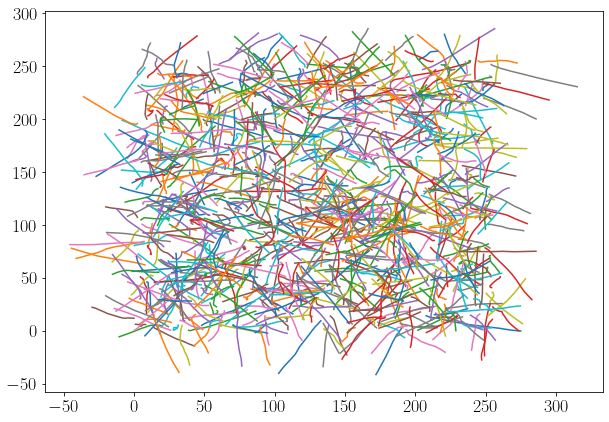

In [7]:
for i in range(n_particles//10):
    plt.plot(xs[:, i, 0], xs[:, i, 1])

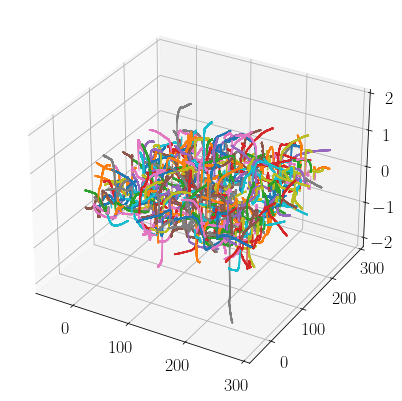

In [8]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = plt.axes(projection='3d')
for i in range(n_particles//20):
    ax.scatter(xs[:, i, 0], xs[:, i, 1], xs[:, i, 2], xs[:, i, 2], s=0.5)

# quadratic and cubic casimirs check

[0.75]


(0.6, 0.9)

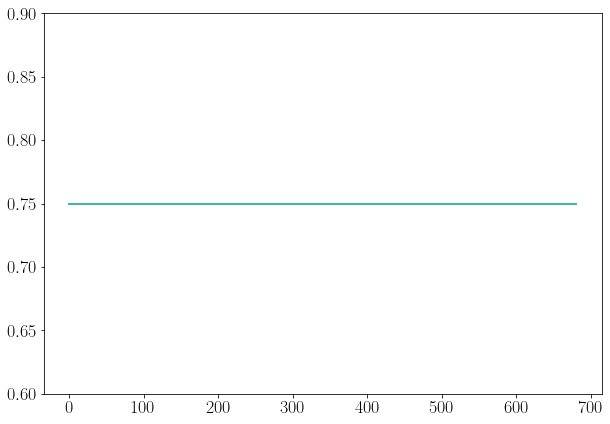

In [9]:
print(cs[1,1,:])
for i in range(n_particles):
    for ci in range(su.CASIMIRS):
        plt.plot(range(t_max), cs[:, i, ci])
# range for SU(2)
plt.ylim([0.6, 0.9])

# plot momentum and position variance

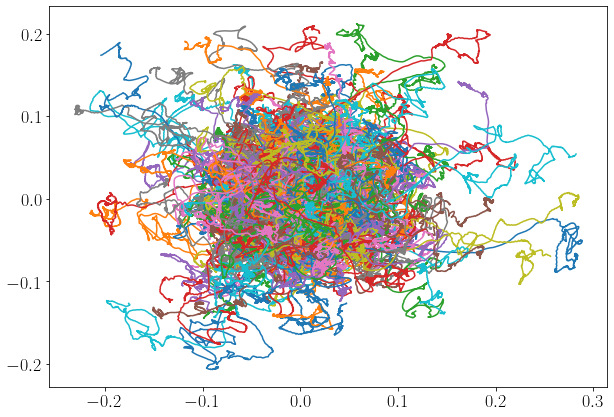

In [10]:
for i in range(n_particles//20):
    plt.plot(ps[:, i, 1], ps[:, i, 2])

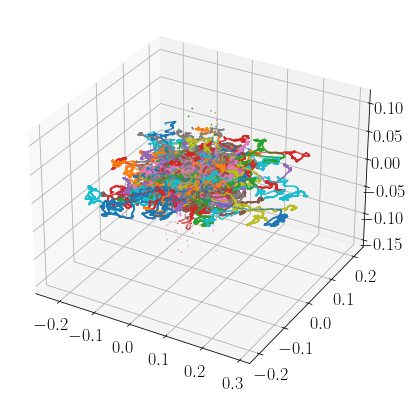

In [11]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = plt.axes(projection='3d')
for i in range(n_particles//20):
    ax.scatter(ps[:, i, 1], ps[:, i, 2], ps[:, i, 3], ps[:, i, 3], s=0.5)

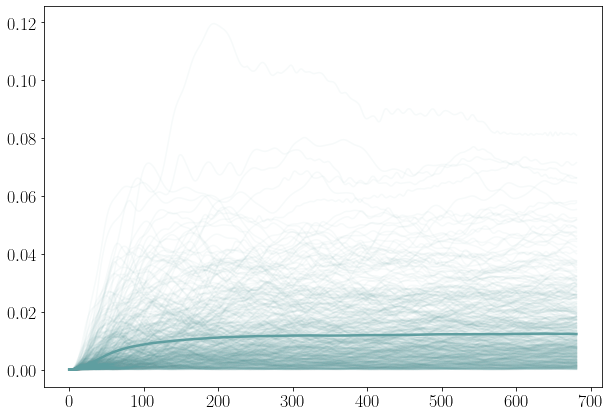

In [7]:
sigmapts = []
for i in range(n_particles//20):
    sigmapt = (ps[:, i, 1]-ps[0, i, 1])**2 + (ps[:, i, 2]-ps[0, i, 2])**2
    plt.plot(range(t_max), sigmapt, alpha=0.05, color="cadetblue")
    sigmapts.append(sigmapt)
sigmap_mean = np.mean(sigmapts, axis=0)
plt.plot(range(t_max), sigmap_mean, color="cadetblue", linewidth=2.5)

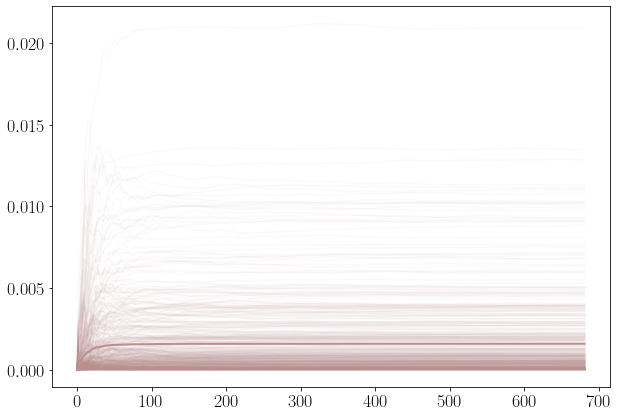

In [13]:
sigmapetas = []
for i in range(n_particles//20):
    sigmapeta = (ps[:, i, 3]-ps[0, i, 3])**2 
    plt.plot(range(t_max), sigmapeta, alpha=0.05, color="rosybrown")
    sigmapetas.append(sigmapeta)
sigmapeta_mean = np.mean(sigmapetas, axis=0)
plt.plot(range(t_max), sigmapeta_mean, color="rosybrown", linewidth=2.)

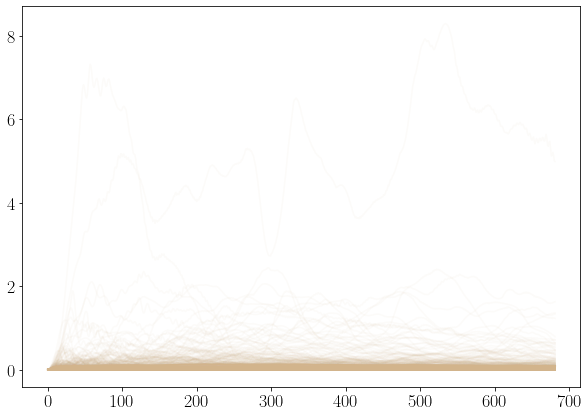

In [14]:
sigmapzs = []
for i in range(n_particles//20):
    pz0 = ps[0, i, 0]*np.sinh(xs[0, i, 2]) + range(t_max)[0]*ps[0, i, 3]*np.cosh(xs[0, i, 2])
    pz = ps[:, i, 0]*np.sinh(xs[:, i, 2]) + range(t_max)[:]*ps[:, i, 3]*np.cosh(xs[:, i, 2])
    sigmapz = (pz-pz0)**2
    plt.plot(range(t_max), sigmapz, alpha=0.05, color="tan")
    sigmapzs.append(sigmapz)
sigmapz_mean = np.mean(sigmapzs, axis=0)
plt.plot(range(t_max), sigmapz_mean, color="tan", linewidth=2.)

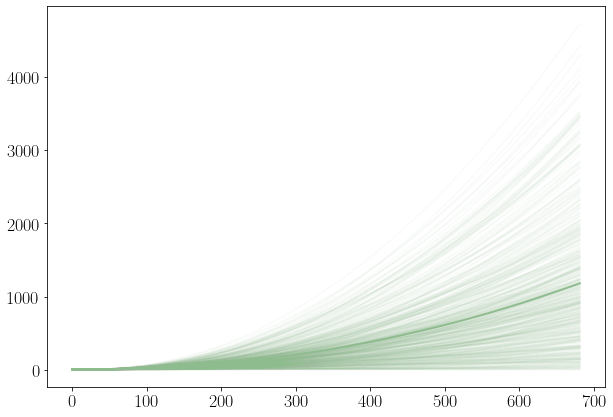

In [15]:
sigmaxs = []
for i in range(n_particles//20):
    sigmax = (xs[:, i, 0]-xs[0, i, 0])**2 + (xs[:, i, 1]-xs[0, i, 1])**2
    plt.plot(range(t_max), sigmax, alpha=0.05, color="darkseagreen")
    sigmaxs.append(sigmax)
sigmax_mean = np.mean(sigmaxs, axis=0)
plt.plot(range(t_max), sigmax_mean, color="darkseagreen", linewidth=2.)

# lorentz force correlators

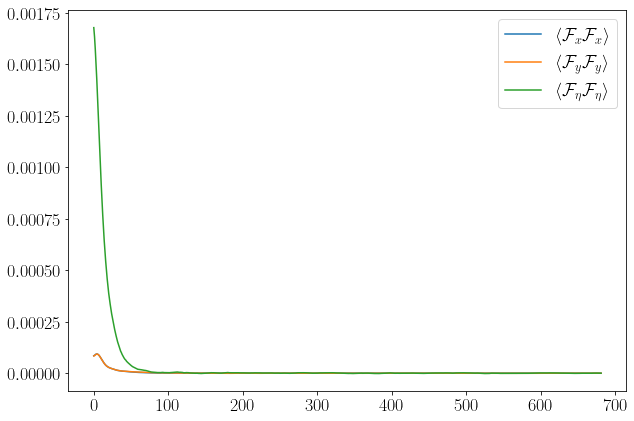

In [16]:
fig, ax = plt.subplots()

corr_avg = np.mean(corr, axis=1)
corr_sum = corr_avg[:, 0]+corr_avg[:, 1]+corr_avg[:, 2]
# plt.plot(range(t_max), corr_sum)
labels = [r'$\langle\mathcal{F}_x\mathcal{F}_x\rangle$', r'$\langle\mathcal{F}_y\mathcal{F}_y\rangle$', r'$\langle\mathcal{F}_\eta \mathcal{F}_\eta\rangle$']
for i in range(3):
    ax.plot(range(t_max), corr_avg[:, i], label=labels[i])
ax.legend()

# run kappa.py

In [10]:
import curraun.kappa as kappa
from tqdm.notebook import tqdm

all_px, all_py, all_pz = [], [], []

Nevents = 10

outer_loop=tqdm(range(Nevents), desc="Event", position=0)
inner_loop=tqdm(range(t_max), desc="Time", position=1)

for e in range(len(outer_loop)):
        s = core.Simulation(N, dt, g)
        va = mv.wilson(s, mu=mu/E0, m=m/E0, uv=uv/E0, num_sheets=ns)
        vb = mv.wilson(s, mu=mu/E0, m=m/E0, uv=uv/E0, num_sheets=ns)
        initial.init(s, va, vb)
        
        kappa_tforce = kappa.TransportedForce(s)
        px, py, pz = [], [], []

        if use_cuda:
            s.copy_to_device()
            kappa_tforce.copy_to_device()
        
        for t in range(len(inner_loop)):
                core.evolve_leapfrog(s)
                
                if use_cuda:
                    kappa_tforce.copy_mean_to_host()

                px.append(kappa_tforce.p_perp_mean[0])
                py.append(kappa_tforce.p_perp_mean[1])
                pz.append(kappa_tforce.p_perp_mean[2]) 
                
                if use_cuda:
                    kappa_tforce.copy_mean_to_device()

                kappa_tforce.compute()
                inner_loop.update()
        
        all_px.append(px)
        all_py.append(py)
        all_pz.append(pz)

        if (e+1)<len(outer_loop):
            inner_loop.refresh()  
            inner_loop.reset()
        outer_loop.update()

px_mean, py_mean, pz_mean = np.mean(all_px, axis=0), np.mean(all_py, axis=0), np.mean(all_pz, axis=0)

Event:   0%|          | 0/10 [00:00<?, ?it/s]

Time:   0%|          | 0/682 [00:00<?, ?it/s]

Text(0.5, 1.0, 'SU(2)')

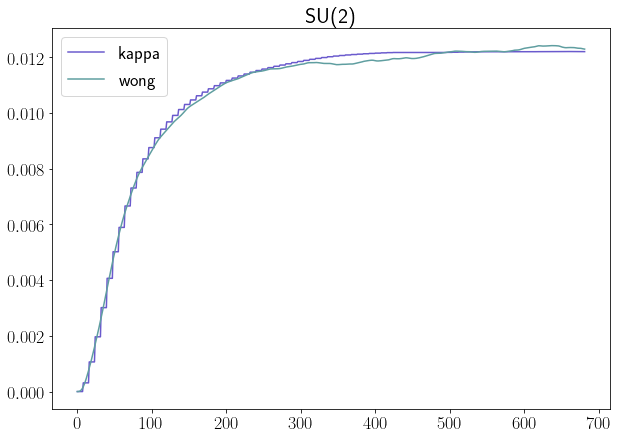

In [11]:
sigmap_kappa = px_mean + py_mean
plt.plot(range(t_max), sigmap_kappa, label='kappa', color="slateblue")
plt.plot(range(t_max), sigmap_mean, label='wong', color="cadetblue")
plt.legend(loc="upper left")
plt.title('SU(2)')
# plt.title('SU(3)')
# plt.ylim(0, 0.02)

In [ ]:
sigmapz_kappa = pz_mean
plt.plot(range(t_max), sigmapz_kappa, label='kappa', color="slateblue")
plt.plot(range(t_max), sigmapz_mean, label='wong', color="cadetblue")
plt.legend(loc="upper left")
plt.title('SU(2)')
# plt.title('SU(3)')
# plt.ylim(0, 0.05)